# CNN training

In [1]:
import os
import re
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [3]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [4]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [5]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)
        
        

In [6]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [7]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Processing

In [8]:
img_width, img_height = 224, 224

In [ ]:
## For all deletions, including common and rare
true_del_file = '/home/rt2776/cnv_espresso/images/true_del_entire_path.list'
false_del_file = '/home/rt2776/cnv_espresso/images/false_del_entire_path.list'

In [9]:
## For rare deletions
true_del_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del.list'
false_del_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del.list'

### Loading cnv image file paths to list

In [10]:
true_del_list = [each_file[0] for each_file in fileToList(true_del_file)]
false_del_list = [each_file[0] for each_file in fileToList(false_del_file)]
len(true_del_list), len(false_del_list)

(5180, 989)

### Loading images from list to numpy array

In [11]:
false_del_img_np = loadImgs(false_del_list, img_width, img_height)
false_del_img_np.shape

[2021.01.15-10:33:37] Processing 1 ...
[2021.01.15-10:35:12] Done 988.


(989, 224, 224, 3)

In [12]:
true_del_img_np = loadImgs(true_del_list, img_width, img_height)
true_del_img_np.shape

[2021.01.15-10:36:45] Processing 1 ...
[2021.01.15-10:38:14] Processing 1001 ...
[2021.01.15-10:39:26] Processing 2001 ...
[2021.01.15-10:41:10] Processing 3001 ...
[2021.01.15-10:42:49] Processing 4001 ...
[2021.01.15-10:44:00] Processing 5001 ...
[2021.01.15-10:44:16] Done 5179.


(5180, 224, 224, 3)

### Generage labels

In [13]:
true_del_label = [1 for i in range(0,len(true_del_img_np))]
false_del_label = [0 for i in range(0,len(false_del_img_np))]
print(true_del_label[0:5], false_del_label[0:5])
print(len(true_del_label), len(false_del_label))

[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]
5180 989


### Combine and shuffle true and false data

In [14]:
del_img = np.vstack((true_del_img_np, false_del_img_np))
del_label = true_del_label + false_del_label

In [15]:
tmp = list(zip(del_img, del_label))
random.shuffle(tmp)
del_img, del_label = zip(*tmp)
del_img_np = np.asarray(del_img)

In [16]:
type(del_img),type(del_img_np)

(tuple, numpy.ndarray)

### Backup or restore

In [16]:
# np.save('/home/rt2776/cnv_espresso/images/rare_del_label', del_label)
# np.save('/home/rt2776/cnv_espresso/images/rare_del_img_np', del_img_np)

In [5]:
# del_label = np.load('/home/rt2776/cnv_espresso/images/del_label.npy')
# del_img_np = np.load('/home/rt2776/cnv_espresso/images/del_img_np.npy')

In [17]:
del_img_np.shape

(6169, 224, 224, 3)

### Split dataset into training(80%) and testing(20%) dataset

In [18]:
train_img, test_img, train_label, test_label = train_test_split(del_img_np,del_label,test_size=0.2,random_state=0)

In [19]:
train_img.shape, test_img.shape

((4935, 224, 224, 3), (1234, 224, 224, 3))

In [20]:
len(train_label), len(test_label)

(4935, 1234)

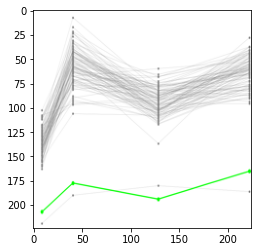

In [22]:
showImg(train_img[0])

### Normalization

In [23]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [24]:
# Change to float datatype
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
test_img /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
test_labels_one_hot = to_categorical(test_label)

In [25]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


1


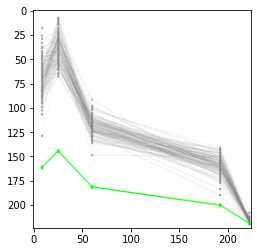

In [57]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train deep nerual network model

In [33]:
model1 = createModel()
batch_size = 60
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_img, test_labels_one_hot), callbacks=[es, mc])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

ResourceExhaustedError:  OOM when allocating tensor with shape[60,32,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/conv2d_1/Conv2DBackpropInput (defined at <ipython-input-33-41393bd5eded>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1593]

Function call stack:
train_function


In [34]:
model1.evaluate(test_img, test_labels_one_hot)

39/39 [==============================] - 3s 86ms/step - loss: 0.2065 - accuracy: 0.9149


[0.2065209150314331, 0.9149108529090881]

In [35]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Accuracy Curves')

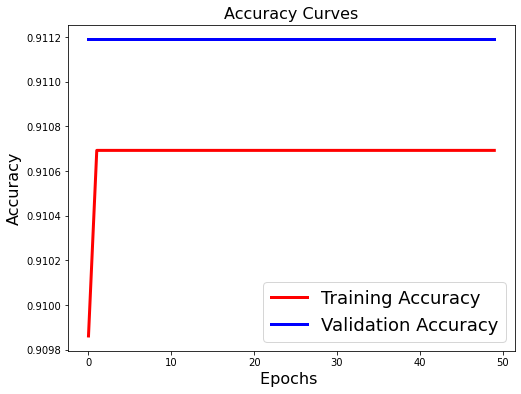

In [32]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- https://zhuanlan.zhihu.com/p/51889181